## Install Packages

## Import 

In [90]:
import sys
from pathlib import Path
from time import sleep
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchinfo import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torchmetrics import ConfusionMatrix
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Setup

In [91]:
## Unzip the data 

!unzip Clothes.zip 

In [92]:
CURRENT_DIR = os.getcwd()
#DATA_DIR = 'Datasets/Clothes'
#PATH_TO_DATA =  os.path.join(CURRENT_DIR,DATA_DIR)
#print(PATH_TO_DATA)

In [93]:
DATA_DIR = Path('Datasets/Clothes/')

DATA_DIR

PosixPath('Datasets/Clothes')

# Visualize an image

In [94]:
import random
from PIL import Image

# set seed
#random.seed(42)
# Get all image paths 
image_path_list = list(DATA_DIR.glob('*/*.jpg'))
 
# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)

Random image path: Datasets/Clothes/Lyon's/36.jpg
Image class: Lyon's
Image height: 256
Image width: 256
Image color_channels: 3


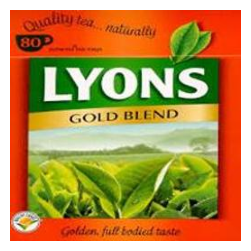

In [95]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image color_channels: {img_as_array.shape[2]}")
# Turn the image into an array

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.axis(False);

In [96]:
import torch
print("Number of CUDA devices available:", torch.cuda.device_count())

num_workers = os.cpu_count()
print(num_workers)

Number of CUDA devices available: 1
24


In [97]:
class PadTensor(object):
    def __init__(self, padding):
        # Padding can be a single integer or a tuple (left, right, top, bottom)
        self.padding = padding  

    def __call__(self, tensor):
        # Pad the tensor and specify the padding mode
        # 'constant' mode adds constant valued padding, and 0 is the padding value
        return torch.nn.functional.pad(tensor, self.padding, mode='constant', value=0)

## Data augmentaion and normalizaion

In [98]:
# Create transform function
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5), # data augmentation
    #transforms.RandomRotation(45),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #transforms.Lambda(lambda image: image.convert('RGB')),
    #transforms.RandomRotation(85),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7)),
    #transforms.ColorJitter(brightness=(0.5,1.5),contrast=(2),saturation=(1.4),hue=(-0.1,0.5)),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std) # normalization
])
transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.CenterCrop((224, 224)),
    #transforms.RandomRotation(45),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std)
])

data_transforms = {
    'train': transforms_train,
    'valid': transforms_valid,
}

In [99]:
transforms_train(img).shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


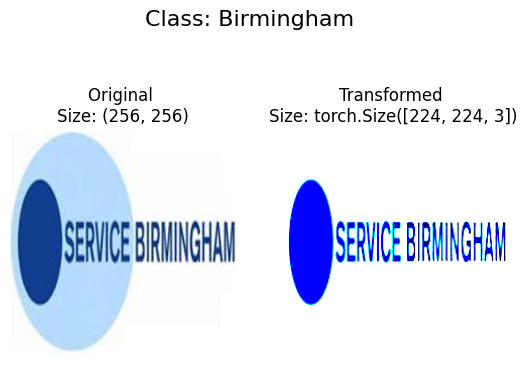

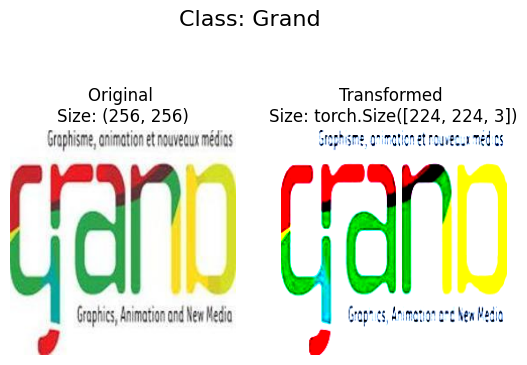

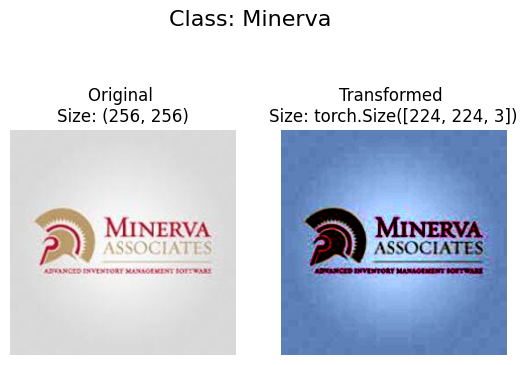

In [100]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=transforms_train, 
                        n=3)

In [101]:
from typing import Tuple, Dict, List
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

## Load Data

## Set up path for data after downloading

In [102]:
from torch.utils.data import random_split
from sklearn.model_selection import KFold
# Load the dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=None)

random.seed(42)
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, test_size])

# Apply different transforms to train and test datasets using a custom Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets with appropriate transformations
train_dataset = CustomDataset(train_dataset, transform=transforms_train)
valid_dataset = CustomDataset(valid_dataset, transform=transforms_valid)

In [103]:
print(len(train_dataset))
print(len(valid_dataset))

16330
4083


In [104]:
img, label = train_dataset[0]
img

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [ 0.8961,  0.8961,  0.8961,  ...,  0.8961,  0.8961,  0.8961],
         [ 0.8961,  0.8961,  0.8961,  ...,  0.8961,  0.8961,  0.8961],
         [ 0.8961,  0.8961,  0.8961,  ...,  0.8961,  0.8961,  0.8961]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [105]:
train_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)

In [106]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Valid dataset size:', len(valid_dataset))
class_names = dataset.classes
#print('Class names:', class_names)

num_classes = len(class_names)
print('Class numbers:', num_classes)
print()
print('Train dataloader size (number of batches):', len(train_dataloader))
print('Valid dataloader size (number of batches):', len(valid_dataloader))
print('Train dataset size:', len(train_dataloader.dataset))
print('Valid dataset size::', len(valid_dataloader.dataset))

Train dataset size: 16330
Valid dataset size: 4083
Class numbers: 286

Train dataloader size (number of batches): 511
Valid dataloader size (number of batches): 128
Train dataset size: 16330
Valid dataset size:: 4083


#  Visualize data after transformation

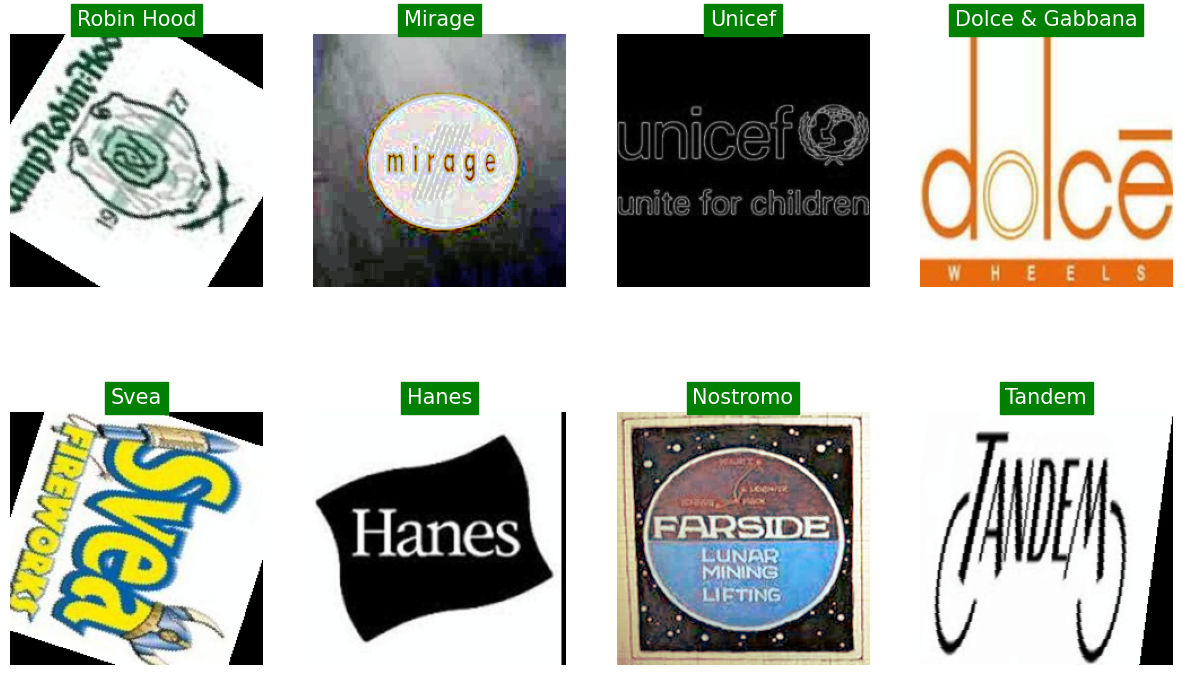

In [107]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(train_dataloader)
inputs, classes = next(iterator)
def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)

plt.show()

## Load pre-trained ResNet-18 model 

In [108]:
class BottleneckWithDropout(nn.Module):
    expansion = 4  # This is specific to ResNet50's Bottleneck block

    def __init__(self, in_planes, planes, stride=1, downsample=None, dropout_rate=0.5):
        super(BottleneckWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        out = self.dropout(out)  # Dropout added after the final ReLU

        return out

In [109]:
class Resnet50(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        
        # Assuming the features output from Resnet50 is of size 2048
        self.classifier_layer = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, num_classes)
            #nn.Linear(128, num_classes)
            # nn.LogSoftmax(dim=1)
        )
        
        self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.named_children():
            if name=='model':
                    for name, child in child.named_children():
                        if name in ['layer3', 'layer4']:
                            for param in child.parameters():
                                param.requires_grad = True
                        else:
                            for param in child.parameters():
                                param.requires_grad = False  
            else: #classifier_layer
                for param in child.parameters():
                    param.requires_grad = True      

In [110]:
model = Resnet50(num_classes=num_classes)
print(model)

Resnet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [111]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
lr = 0.0001 
# I can use other optimizers like adam 
optimizer = optim.Adam(model.parameters(), lr=lr)# Use all parameters
scheduler = ExponentialLR(optimizer, gamma=0.9)
# Optimizers to compare ##TODO
optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9),
    'Adam': optim.Adam(model.parameters(), lr=0.0001),
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.0001)
    # Add any other optimizers you want to compare
}

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

cuda:0


In [112]:
#train_loader = train_dataloader
#valid_loader = dataloaders['valid']

In [113]:
import datetime
import os
current_datetime = datetime.datetime.now()

# Extract the date, hour, and minute parts
current_date = current_datetime.date()
current_hour = current_datetime.hour
current_minute = current_datetime.minute
FILE_NAME = f'{current_date}_{current_hour}:{current_minute}'
current_exp_dir = f'models/{FILE_NAME}'

In [114]:
def train_model(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         device: torch.device=device):
    model.to(device)
    # training mode
    model.train()
    train_loss , train_corrects = 0.0  , 0 
        # loop through the training batches..
    for batch, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        
        # forward inputs and get output
        outputs = model(inputs)

        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item() * inputs.size(0)
            
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
        
         # Calculate Accuracy
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data).item()

        if batch % 100 == 0:
            print(f'Looked at {batch * len(inputs)}/{len(data_loader.dataset)} samples.')
                

    #scheduler.step()    
    avg_train_loss = train_loss / len(data_loader.dataset)
    avg_train_acc = train_corrects / len(data_loader.dataset) * 100
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    # Print progress
    print('.............')
    print('Train Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(avg_train_loss, avg_train_acc, weighted_f1))
    return avg_train_loss, avg_train_acc, weighted_f1
    

In [1]:
def valid_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device=device):
    model.to(device)
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    y_pred = []
    y_true = []
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        
         # Calculate Accuracy
        _, preds = torch.max(outputs, 1)
        val_corrects += torch.sum(preds == labels.data).item()
        
        # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    avg_valid_loss = val_loss / len(data_loader.dataset)
    avg_valid_acc = val_corrects / len(data_loader.dataset) * 100

    # Calculate the weighted F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    print('Valid Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(avg_valid_loss, avg_valid_acc, weighted_f1))

    return [avg_valid_loss, avg_valid_acc, y_pred, y_true, weighted_f1]

NameError: name 'device' is not defined

## Train the model on custom data 

In [116]:
# Initialize best accuracy and initialize model weights
class_names = dataset.classes
num_classes = len(class_names)

#batch_size = 32
num_epochs = 100
epochs = range(num_epochs)

# train
epoch_train_loss=[]
train_accuracy=[]
train_weighted_f1=[]
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]

best_acc = 0.0
y_pred = []
y_true = []


os.makedirs(current_exp_dir, exist_ok=True)
start_time = time.time()
# Start Training loop
with tqdm(total=len(epochs), file=sys.stdout) as pbar:
    pbar.set_description('Processed:')
    for epoch in epochs:
        pbar.set_description('Processed:')
        pbar.update(1)
        print()

            #print("Epoch {}/{} running....".format(epoch+1, num_epochs)) #(printing message)

        """ Training Phase """
        avg_train_loss, avg_train_acc, weighted_f1 = train_model(model, train_dataloader, loss_fn, optimizer, device)
        # Append result
        epoch_train_loss.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)
        train_weighted_f1.append(weighted_f1)


        """ Validation Phase """
        history = valid_model(model, valid_dataloader, loss_fn, device)
        # Append result
        valid_loss.append(history[0])
        valid_accuracy.append(history[1])
        valid_weighted_f1.append(history[4])
        y_pred.extend(history[2])
        y_true.extend(history[3])
                          # Save the best model
        if history[1] > best_acc:
            best_acc = history[1]
            torch.save(model.state_dict(), f'{current_exp_dir}/resnet_best.pth')
            print('Improvement-Detected, Best model updated')
        print('.............')
        
        print()
torch.save(model.state_dict(), f'{current_exp_dir}/resnet_last.pth')
time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}%'.format(best_acc))

Processed::   0%|          | 0/100 [00:00<?, ?it/s]
Looked at 0/16330 samples.
Looked at 3200/16330 samples.
Looked at 6400/16330 samples.
Looked at 9600/16330 samples.
Looked at 12800/16330 samples.
Looked at 16000/16330 samples.
.............
Train Loss: 5.0031 | Acc: 12.4617% | Weighted F1: 0.0000
Valid Loss: 4.2970 | Acc: 22.8019% | Weighted F1: 16.3184
Improvement-Detected, Best model updated
.............

Processed::   2%|▏         | 2/100 [03:01<2:28:00, 90.61s/it] 
Looked at 0/16330 samples.
Looked at 3200/16330 samples.
Looked at 6400/16330 samples.
Looked at 9600/16330 samples.
Looked at 12800/16330 samples.
Looked at 16000/16330 samples.
.............
Train Loss: 4.1246 | Acc: 25.4501% | Weighted F1: 16.3184
Valid Loss: 3.6365 | Acc: 32.0108% | Weighted F1: 26.2695
Improvement-Detected, Best model updated
.............

Processed::   3%|▎         | 3/100 [06:01<3:26:37, 127.81s/it]
Looked at 0/16330 samples.
Looked at 3200/16330 samples.
Looked at 6400/16330 samples.
Looked

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(32,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      [32, 286]                 --
├─ResNet: 1-1                                 [32, 2048]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         (70,400)
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]      

## Ploting

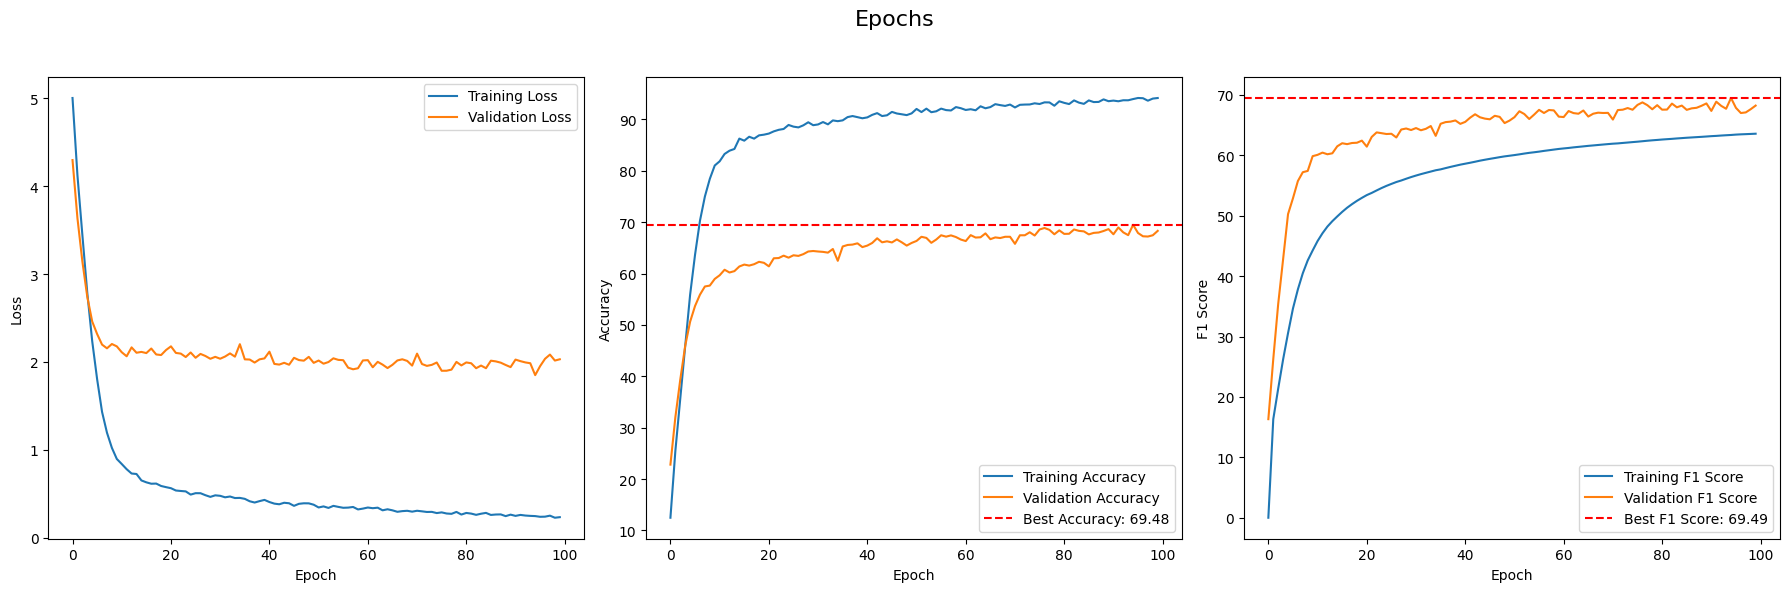

In [118]:
from utilities import visual
settings = { 'num_epochs': num_epochs, 'batch_size':batch_size,
            'criterion': 'CrossEntropyLoss', 
             'optimizer': 'Adam', 'lr': lr,
}
history = {
    'Training_Loss': epoch_train_loss,
    'Validation_Loss': valid_loss,
    'Training_Accuracy': train_accuracy,
    'Validation_Accuracy': valid_accuracy,
    'Training_F1_Score': train_weighted_f1,
     'Validation_F1_Score': valid_weighted_f1,
    
    'file_name': FILE_NAME,
}

title = 'Epochs'
visual.plot_results(history, title)

In [119]:
import json
with open(f'{current_exp_dir}/settings.json', 'w') as file:
    json.dump(settings, file)

In [ ]:
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]
y_pred = []
y_true = []
history_val = valid_model(model, valid_dataloader, loss_fn, device)
        # Append result
y_pred.extend(history_val[2])
y_true.extend(history_val[3])

In [ ]:
print('Weighted F1: {:.4f}'.format(history_val[4]))

In [120]:
print("Accuracy on Validation set: ", accuracy_score(y_true, y_pred))
classificationReport = classification_report(y_true, y_pred)
with open(f'{current_exp_dir}/classificationReport.txt', 'w') as file:
    file.write(f'Classification report:\n {classificationReport}')
    file.close()
    
print('Classification report: \n', classificationReport)

Accuracy on Validation set:  0.6406147440607397
Classification report: 
               precision    recall  f1-score   support

           0       0.24      0.24      0.24      1300
           1       0.79      0.88      0.83      1600
           2       0.58      0.51      0.54      2400
           3       0.47      0.47      0.47       900
           4       0.77      0.69      0.73      2400
           5       0.73      0.75      0.74      1100
           6       0.86      0.89      0.87      1000
           7       0.73      0.90      0.81      1800
           8       0.90      0.94      0.92      1700
           9       0.67      0.63      0.65      1500
          10       0.66      0.60      0.63      1700
          11       0.68      0.74      0.71      1500
          12       0.53      0.69      0.60       900
          13       0.17      0.18      0.17      1600
          14       0.93      0.95      0.94      1800
          15       0.43      0.42      0.42       700
        

In [ ]:
# Build confusion matrix
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for logos classification ")
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(f'{current_exp_dir}/Confusion_Matrix.png')
plt.show()

Confusion matrix: 
 [[ 317    0    0 ...    1    0    3]
 [   0 1400    5 ...    0    0    0]
 [   2    0 1233 ...    1    4    2]
 ...
 [   0    0    0 ... 1432    0    0]
 [   0    0    0 ...    0 1264    0]
 [   0    2    0 ...    0    1  808]]


In [ ]:
class_names = dataset.classes

y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred, target=y_true)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
import seaborn as sns
confmat_normalized = confmat_tensor.numpy().astype('float') / confmat_tensor.numpy().sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confmat_tensor.numpy(), annot=True, ax=ax, cmap='viridis', fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90) 
ax.set_yticklabels(class_names)
plt.show()


# Load Saved Model

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

model = Resnet50(num_classes=num_classes)

model.load_state_dict(torch.load(f'{current_exp_dir}/resnet_best.pth'))
model.eval()


### USE MODEL OR NEW_MODEL 
# Create a new model and adjust its final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Linear(new_model.fc.in_features, num_classes),
    nn.Sigmoid()
)
# Correctly copy the weights and biases from the loaded model to the new model
#new_model.fc[0].weight.data = model.fc[0].weight.data.clone()
#new_model.fc[0].bias.data = model.fc[0].bias.data.clone()

### Get some images from the Dataset

### Evaluation 

## Clasification on unseen Image

In [ ]:
# Load and preprocess the unseen image
image_path = 'img/boeing_img000019_34_0.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [ ]:
with open("Datasets/brands.txt", "r") as file:
    lines = file.readlines()

lines_upper = [line.upper() for line in lines]

unique_lines = set()
duplicate_lines = []

for line in lines_upper:
    if line in unique_lines:
        duplicate_lines.append(line)
    else:
        unique_lines.add(line)
print(f'{len(unique_lines)} Brands')